In [1]:
import mitsuba as mi 
mi.set_variant("cuda_ad_rgb")
import drjit as dr 
from matplotlib import pyplot as plt
from PDE3D import PATH
import numpy as np
from PDE3D.BoundaryShape import *
from PDE3D.utils import *
import os
import numpy as np
from PDE3D.Coefficient import *
from PDE3D.Solver import *

In [2]:
name = "motorbike-engine"
solution_resolution = [64,64,4]
solution_spp = 1024
res_slice = [512, 512]
folder_name = os.path.join(PATH, "scenes", name)
xml_name = os.path.join(folder_name, "scene.xml")
sdf_data = np.load(os.path.join(folder_name, "sdf.npy"))
cam_res = [512, 512]
res_slice = [512, 512]
spp = 64
downsample = 1
sdf_data = sdf_data[::downsample,::downsample,::downsample]
cam_origin = mi.ScalarPoint3f([7,7,10])
scale_cam = 1/5
cam_target = mi.ScalarPoint3f([0.0,0.0,0.0])
cam_up = mi.ScalarPoint3f([0,1,0])

slice = Slice(offset =0, scale = 7, axis = "z")
res_slice = [128, 128]
cmap = "viridis"
sym = False

In [3]:
def dirichlet(points, params):
    return dr.sin(points[0] * params["x"]) + dr.cos(points[1] * points[2] * params["yz"])
params1 = {}
params1["x"] = 0.2
params1["yz"] = 0.4

params2 = {}
params2["x"] = 4
params2["yz"] = 0.4

boundary_cond1 = FunctionCoefficient("dirichlet", params1, dirichlet)
boundary_cond2 = FunctionCoefficient("dirichlet", params2, dirichlet)
boundary_cond3 = ConstantCoefficient("dirichlet", 0)

In [4]:
sdf = SDF(sdf_data, mesh_scene_xml=xml_name, dirichlet = [boundary_cond1, boundary_cond2, boundary_cond3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.6910927].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.6910927].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.6910927].


Text(0.5, 1.0, 'Boundary Condition')

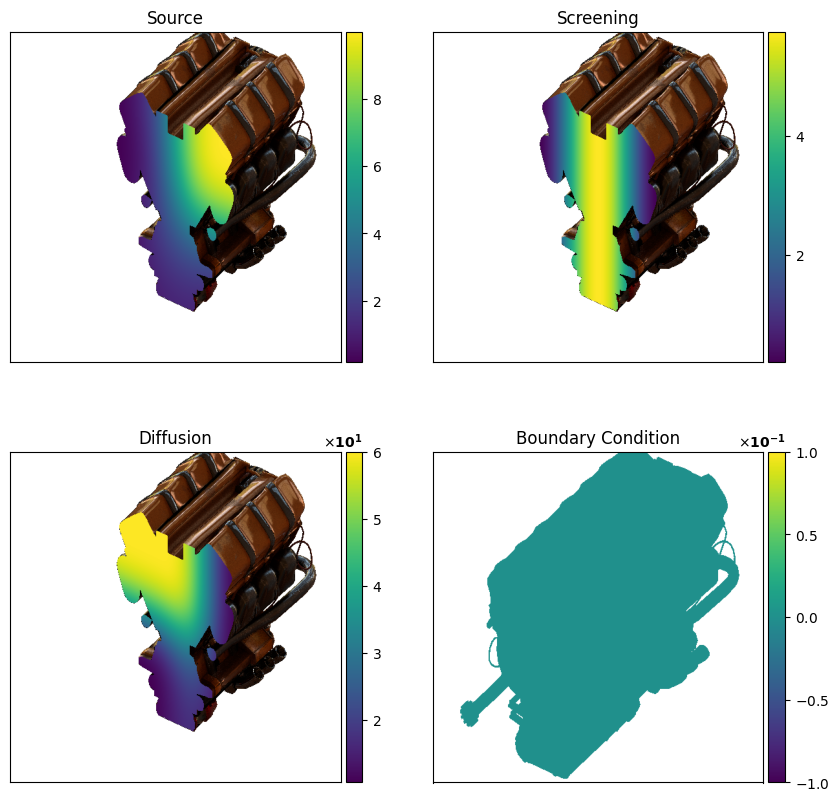

In [5]:
source = np.array([[0,0,0,0],
                  [1,2,1,2],
                  [1,3,10,10],
                  [1,1,10,10]])
source = source[:,:,np.newaxis]

screening = np.array([[0,0,0,0],
                      [6,6,6,6],
                      [6,6,6,6],
                      [0,0,0,0]])
screening = screening[:,:,np.newaxis]

diffusion = np.array([[1,1,6,6],
                      [1,1,6,6],
                      [2,3,6,6],
                      [1,1,1,1]]) * 10
diffusion = diffusion[:,:,np.newaxis]

bbox = sdf.mesh_scene.bbox()
bbox_pad = (bbox.max - bbox.min) / 10
bbox_coeff = mi.ScalarBoundingBox3f(bbox.min - bbox_pad, bbox.max + bbox_pad)
f = TextureCoefficient("source", bbox_coeff, source)
σ = TextureCoefficient("screening", bbox, screening)
α = TextureCoefficient("diffusion", bbox, diffusion)

points, _ = slice.create_slice_points(resolution = res_slice, spp = 1, centered = True)
f_vals = f.get_value(points)
σ_vals = σ.get_value(points)
α_vals = α.get_value(points)

#f_image, f_tensor = create_slice_from_result(result = f_vals, resolution = res_slice)
#σ_image, σ_tensor = create_slice_from_result(result = σ_vals, resolution = res_slice)
#α_image, α_tensor = create_slice_from_result(result = α_vals, resolution = res_slice)

f3D, f_norm = sdf.visualize(colormap = cmap, cam_origin= cam_origin, spp = spp, image_res = cam_res, 
                            scale_cam=scale_cam, cam_up = cam_up, slice = slice, cam_target = cam_target, coeff=f)
σ3D, σ_norm = sdf.visualize(colormap = cmap, cam_origin= cam_origin, spp = spp, image_res = cam_res, 
                            scale_cam=scale_cam, cam_up = cam_up, slice = slice, cam_target = cam_target, coeff=σ)
α3D, α_norm = sdf.visualize(colormap = cmap, cam_origin= cam_origin, spp = spp, image_res = cam_res, 
                            scale_cam=scale_cam, cam_up = cam_up, slice = slice, cam_target = cam_target, coeff= α)

dirichlet3D, dirichlet_norm = sdf.visualize(colormap = cmap, cam_origin= cam_origin, spp = spp, image_res = cam_res, 
                            scale_cam=scale_cam, cam_up = cam_up,cam_target = cam_target, conf_number=2)

fig, ax = plt.subplots(2,2, figsize = (10,10))

plot_image_3D(f3D, ax[0,0], norm = f_norm, cmap = cmap)
plot_image_3D(σ3D, ax[0,1], norm = σ_norm, cmap = cmap)
plot_image_3D(α3D, ax[1,0], norm = α_norm, cmap = cmap)
plot_image_3D(dirichlet3D, ax[1,1], norm = dirichlet_norm, cmap = cmap)

ax[0,0].set_title("Source")
ax[0,1].set_title("Screening")
ax[1,0].set_title("Diffusion")
ax[1,1].set_title("Boundary Condition")

In [6]:
data_holder = DataHolder(f=f, σ=σ, α=α, shape = sdf)
default_majorant = data_holder.σ_bar
solutions = []
k = 5  
for i in range(k):
    data_holder = DataHolder(f=f, σ=σ, α=α, shape = sdf, default_majorant= i * default_majorant / 2 + default_majorant)
    wos = WosVariable(input=data_holder, max_z = 5, seed = i)
    points = create_bbox_points(bbox, resolution = solution_resolution, spp = solution_spp, centered=True)
    print(wos.input.σ_bar)
    L, _ = wos.solve(points, split = Split.Normal, conf_numbers=[mi.UInt32(0), mi.UInt32[1], mi.UInt32[2]])
    solution_image, solution_tensor = create_volume_from_result(L, solution_resolution)
    solutions.append(solution_image)

[1.12238]
0 : 16777216 -> 13745
1 : 13745 -> 306
2 : 306 -> 8
3 : 8 -> 0
[1.68357]
0 : 16777216 -> 8728
1 : 8728 -> 97
2 : 97 -> 1
3 : 1 -> 0
[2.24476]
0 : 16777216 -> 6280
1 : 6280 -> 35
2 : 35 -> 0
[2.80596]
0 : 16777216 -> 4710
1 : 4710 -> 23
2 : 23 -> 0
[3.36715]
0 : 16777216 -> 3621
1 : 3621 -> 20
2 : 20 -> 0


In [7]:
solutions[0].shape

(3, 64, 64, 4)

In [8]:
fig, ax = plt.subplots(k, 3, figsize = (15, k * 5))
slice = Slice(offset = -2, scale = 10, axis = "z")
conf_number = 2
for i in range(k):
    solution_tex = TextureCoefficient("solution", bbox, tensor_np=solutions[i][conf_number], interpolation = "nearest")
    diff_tex = TextureCoefficient("solution", bbox, tensor_np=solutions[i][conf_number] - solutions[0][conf_number], interpolation = "nearest")
    solution3D, soln_norm = sdf.visualize(colormap = cmap, cam_origin= cam_origin, spp = spp, image_res = cam_res, 
                                          scale_cam=scale_cam, cam_up = cam_up, slice = slice, cam_target = cam_target, coeff=solution_tex)
    diff3D, diff_norm = sdf.visualize(colormap = cmap, cam_origin= cam_origin, spp = spp, image_res = cam_res, 
                                          scale_cam=scale_cam, cam_up = cam_up, slice = slice, cam_target = cam_target, coeff=diff_tex)
    solution3D, soln_norm = sdf.visualize(colormap = cmap, cam_origin= cam_origin, spp = spp, image_res = cam_res, 
                            scale_cam=scale_cam, cam_up = cam_up, slice = slice, cam_target = cam_target, coeff=solution_tex)
    diff3D, diff_norm = sdf.visualize(colormap = "coolwarm", cam_origin= cam_origin, spp = spp, image_res = cam_res, 
                                      scale_cam=scale_cam, cam_up = cam_up, slice = slice, cam_target = cam_target, coeff=diff_tex, sym_colorbar=True)
    plot_image_3D(solution3D, ax[i,0], norm = soln_norm, cmap = cmap)
    plot_image_3D(diff3D, ax[i,1], norm = diff_norm, cmap = "coolwarm")
    ax[0,0].set_title("Solution")
    ax[0,1].set_title("Difference")
    diff = (solutions[i][conf_number] - solutions[0][conf_number]).flatten()
    diff = diff[diff != 0]
    if i>0:
        ax[i,2].hist(diff, bins = 50)
        max = np.maximum(np.max(diff), np.max(-diff))
        ax[i,2].set_xlim([-max, max])
        #ax[i,2].set_xlim([-0.005, 0.005])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.400743].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.400743].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.400743].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.400743].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.400743].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.400743].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.400743].
Clipping input data to the valid range fo